In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import shutil
import numpy as np

In [9]:
# matplotlib settings to match LaTeX fonts and style
latex_path = shutil.which("latex")
print("LaTeX found at:", latex_path if latex_path else "Not found in PATH")

mpl.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",  # Computer Modern serif
        "text.latex.preamble": r"\usepackage[T1]{fontenc}\usepackage{amsmath,amssymb,bm}",
        "axes.labelsize": 9,  # adjust to match \small or \normalsize
        "font.size": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
    }
)


def set_size(width_pt=455, fraction=1, aspect=0.62):
    """Set figure dimensions to fit LaTeX doc."""
    inches_per_pt = 1 / 72.27
    width_in = width_pt * inches_per_pt * fraction
    height_in = width_in * aspect
    return (width_in, height_in)

LaTeX found at: /Library/TeX/texbin/latex


In [10]:
def get_df(model, table, ra, seed):
    path = f"results/{model}/{table}/ra{ra}-{seed}.csv"
    if not os.path.exists(path):
        return None
    df = pd.read_csv(path)
    df["model"] = model
    df["ra"] = ra
    df["seed"] = seed
    return df


models = ["3d-lran", "3d-fno", "3d-lstm"]
ras = [2500]
seeds = [0, 1, 2]

metric = "nrsse"

# collect all data into one big DataFrame
df = pd.concat(
    [get_df(m, "metrics", r, seed) for m in models for r in ras for seed in seeds],
    ignore_index=True,
)


def model2name(model):
    if model == "3d-lran":
        return "LRAN"
    elif model == "3d-fno":
        return "FNO"
    elif model == "3d-lstm":
        return "AE+LSTM"
    else:
        return model

# Prediction Error vs Ra

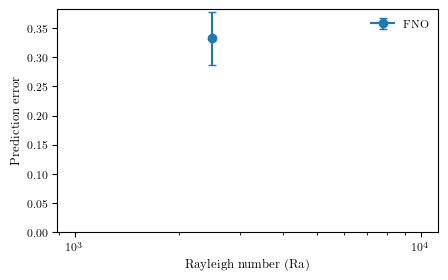

In [11]:
# TODO debug filter; filter out steps above 30
# df = df[df["step"] <= 30]
# df = df[df["ra"] >= 300000]

# 1) collapse each run (model, ra, seed) to a single scalar: mean error over all samples & timesteps
per_run = (
    df.groupby(["model", "ra", "seed"], as_index=False)[metric]
    .mean()
    .rename(columns={metric: "run_mean"})
)

# 2) aggregate across seeds (between-run variability)
summary = (
    per_run.groupby(["model", "ra"])["run_mean"]
    .agg(mu="mean", sigma="std", n_runs="count", best="min", median="median")
    .reset_index()
)

# standard error and 95% CI for convenience
# summary["se"] = summary["sigma"] / np.sqrt(summary["n_runs"]).replace(0, np.nan)
# summary["ci95"] = 1.96 * summary["se"]

# nice sort by Ra (numeric) and model
summary = summary.sort_values(["model", "ra"]).reset_index(drop=True)
fig, ax = plt.subplots(figsize=set_size(455, fraction=0.7))

for model, sub in summary.groupby("model"):
    x = sub["ra"].values
    y = sub["mu"].values
    yerr = sub["sigma"].values
    ax.errorbar(x, y, yerr=yerr, marker="o", capsize=3, label=model2name(model))

ax.set_xlabel(r"Rayleigh number ($\mathrm{Ra}$)")
ax.set_ylabel(r"Prediction error")
ax.set_xscale("log")
ax.set_ylim(bottom=0)
ax.legend(frameon=False)
fig.tight_layout(pad=0.5)

# --- Save as vector PDF for LaTeX ---
fig.savefig("figs/error_vs_ra.pdf")

# Prediction Error vs Time in Sequence

     model  step        mu     sigma
99  3d-fno    99  0.692051  0.081593


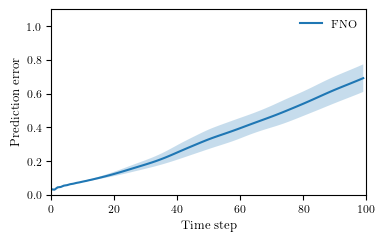

In [12]:
RA = 2500

d = df.copy()
d = d[d["ra"] == RA]

# 1) Per-run, per-time mean and std over samples (within-run stats)
# count is helpful for pooled std later
per_run_time = (
    d.groupby(["model", "seed", "step"])[metric].agg(run_mean="mean").reset_index()
)

# 2) Aggregate across seeds at each time
across = (
    per_run_time.groupby(["model", "step"])["run_mean"]
    .agg(mu="mean", sigma="std")
    .reset_index()
    .sort_values(["model", "step"])
    .reset_index(drop=True)
)

print(across[across["step"] == 99])

fig, ax = plt.subplots(figsize=set_size(455, fraction=0.6))

for model, sub in across.groupby("model"):
    x = sub["step"].values
    mu = sub["mu"].values
    sig = sub["sigma"].values
    plt.plot(x, mu, label=model2name(model))
    plt.fill_between(x, mu - sig, mu + sig, alpha=0.25)

ax.set_xlabel(r"Time step")
ax.set_ylabel(r"Prediction error")
# ax.set_title(rf"Rayleigh number ($\mathrm{{Ra}}={RA:.0e}$)")
ax.set_ylim(bottom=0, top=1.1)
ax.set_xlim(left=0, right=100)
ax.legend(frameon=False)
fig.tight_layout(pad=0.5)

# --- Save as vector PDF for LaTeX ---
fig.savefig(f"figs/error_vs_time_ra{RA}.pdf")

## Nusselt Number

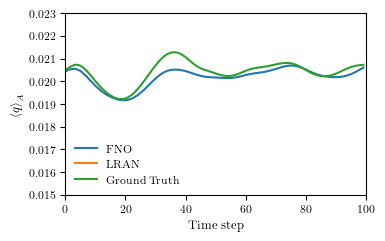

In [13]:
df_nu = pd.concat(
    [get_df(m, "nusselt", r, seed) for m in models for r in ras for seed in seeds],
    ignore_index=True,
)

RA = 2500
df_nu = df_nu[df_nu["ra"] == RA]

# get mean per step and nodel
mean_df = df_nu.groupby(["step", "model"], as_index=False)[
    ["nu_pred", "nu_target"]
].mean()

# get per model
mean_df_lran = mean_df[mean_df["model"] == "3d-lran"]
mean_df_fno = mean_df[mean_df["model"] == "3d-fno"]


fig, ax = plt.subplots(figsize=set_size(455, fraction=0.6))
plt.plot(mean_df_fno["step"], mean_df_fno["nu_pred"], label="FNO")
plt.plot(mean_df_lran["step"], mean_df_lran["nu_pred"], label="LRAN")
plt.plot(mean_df_fno["step"], mean_df_fno["nu_target"], label="Ground Truth")


ax.set_xlabel(r"Time step")
ax.set_ylabel(r"${\langle q \rangle}_A$")
# ax.set_title(rf"Rayleigh number ($\mathrm{{Ra}}={RA:.0e}$)")
ax.set_ylim(bottom=0.015, top=0.023)
ax.set_xlim(left=0, right=100)
ax.legend(frameon=False)
fig.tight_layout(pad=0.5)

plt.show()

# Q Profile

KeyError: '3d-lran'

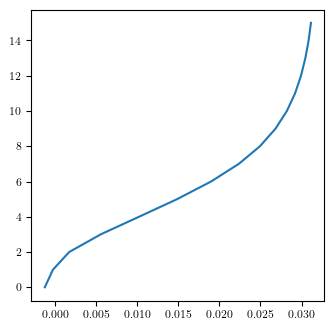

In [14]:
df_q_profile = pd.concat(
    [get_df(m, "q-profile", r, seed) for m in models for r in ras for seed in seeds],
    ignore_index=True,
)

# get mean per step and nodel
df_q_profile = df_q_profile.groupby(["height", "model"], as_index=False)[
    ["q_pred", "q_target"]
].mean()

wide_q_df = df_q_profile.pivot(
    index="height", columns="model", values="q_pred"
).reset_index()
wide_q_df["q_target"] = df_q_profile.groupby("height")["q_target"].first().values

cutoff = wide_q_df["height"].max() / 2
df_q_half = wide_q_df[wide_q_df["height"] <= cutoff]

fig, ax = plt.subplots(figsize=set_size(455, fraction=0.6, aspect=1))

for model, label in zip(["3d-fno", "3d-lran"], ["FNO", "LRAN"]):
    plt.plot(df_q_half[model], df_q_half["height"], label=label)
plt.plot(df_q_half["q_target"], df_q_half["height"], "k--", label="Ground Truth")

ax.set_xlabel(r"${\langle q \rangle}_{xy}$")
ax.set_ylabel(r"z")
ax.set_ylim(bottom=0, top=cutoff - 1)
ax.set_yticks([0, 7.5, 15], labels=[-1, -0.5, 0])

ax.legend(frameon=False)
fig.tight_layout(pad=0.5)

plt.show()

# Q' Profile

In [ ]:
df_qp_profile = pd.concat(
    [get_df(m, "qp-profile", r, seed) for m in models for r in ras for seed in seeds],
    ignore_index=True,
)

# get mean per step and nodel
df_qp_profile = df_qp_profile.groupby(["height", "model"], as_index=False)[
    ["q_pred", "q_target"]
].mean()

wide_qp_df = df_qp_profile.pivot(
    index="height", columns="model", values="q_pred"
).reset_index()
wide_qp_df["q_target"] = df_qp_profile.groupby("height")["q_target"].first().values

cutoff = wide_qp_df["height"].max() / 2
df_qp_half = wide_qp_df[wide_qp_df["height"] <= cutoff]

fig, ax = plt.subplots(figsize=set_size(455, fraction=0.6, aspect=1))

for model, label in zip(["3d-fno", "3d-lran"], ["FNO", "LRAN"]):
    plt.plot(df_qp_half[model], df_qp_half["height"], label=label)
plt.plot(df_qp_half["q_target"], df_qp_half["height"], "k--", label="Ground Truth")

ax.set_xlabel(r"${\langle q \rangle}_{xy}$")
ax.set_ylabel(r"z")
ax.set_ylim(bottom=0, top=cutoff - 1)
ax.set_yticks([0, 7.5, 15], labels=[-1, -0.5, 0])

ax.legend(frameon=False)
fig.tight_layout(pad=0.5)

plt.show()

# Q' Histogram

In [29]:
df_hist = pd.concat(
    [get_df(m, "qp-histogram", r, seed) for m in models for r in ras for seed in seeds],
    ignore_index=True,
)

#z = 5 #  [5, 16, 26]
#df_hist = df_hist[df_hist["height"] == z]

# get edges
xlim = (-1, 1)
bins = 100
edges = np.linspace(xlim[0], xlim[1], bins + 1)

# accumulate over seeds and batches
results = {}
for key, rows in df_hist.groupby(["height","model","ra"]):
    H = np.stack(rows["hist_pred"].to_numpy(), axis=0)  # [N, bins]
    print(H)

    pdf_mean = H.mean(axis=0)
    results[key] = {"pdf_mean": pdf_mean, "n_items": H.shape[0]}

print(results)

['[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.039496528660593985, 2.2484809530352434, 25.707682866278155, 15.531250347150499, 6.090060900012357, 0.3689236193571966, 0.014105903093069283, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]'
 '[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.019748264330296993, 0.27105035328066973, 2.0188802534588235, 25.727648144502194, 15.440321525673635, 5.998264022960537, 0.5173611226750333, 0.00672743070

TypeError: the resolved dtypes are not compatible with add.reduce. Resolved (dtype('<U639'), dtype('<U639'), dtype('<U1278'))